**Clasificación de pacientes con covid, usando imágenes de radiografía y algoritmos cuánticos híbridos**



Para la clasificación de imágenes se propone crear una red neuronal híbrida cuántica-clásica que utiliza TorchConnector. Que consta de una primera parte con redes neuronales clasicas con diferentes capas, junto con una etapa del algoritmo cuántico QNN.

Más adelante se mostraran los diferentes experimentos que se hicieron con diferente número de capas, diferente número de kernels y diferente tamaño de las imágenes.

Se instalan los paquetes necesarios.


In [9]:
pip install qiskit

In [10]:
pip install qiskit_machine_learning

Se importan las librerias necesarias

In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

from torch import Tensor
from torchvision.io import read_image, image
import os
from torchvision.utils import make_grid
from pathlib import Path
from torchvision import transforms
from PIL import Image as imagePIL
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector




**Definiendo dataset de imágenes para entrenamiento y test.**

Se creo un dataset con con radiografías de tórax de personas con covid y personas sanas.de 251 kb.
El dataset esta dividido de la siguiente manera para entrenamiento:
- 78 imágenes de radiografías de tórax de pacientes con COVID.
- 498 imágenes de radiografías de tórax de pacientes sanos.


Para test:
- 12 imágenes de radiografías de tórax de pacientes con COVID.
- 69 imágenes de radiografías de tórax de pacientes sanos.



In [12]:

batch_size = 1
transformar = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
!rm -R bancos/train/.ipynb_checkpoints #necesario si corres tu programa en colab

train = datasets.ImageFolder('bancos/train/',transform=transformar)

!rm -R bancos/test/.ipynb_checkpoints #necesario si corres tu programa en colab
test = datasets.ImageFolder('bancos/test/',transform=transformar)


train_data = DataLoader(train, batch_size=1, shuffle=True)
test_data = DataLoader(test, batch_size=1, shuffle=True)
print(train_data)
print(test_data)


rm: cannot remove 'bancos/train/.ipynb_checkpoints': No such file or directory
rm: cannot remove 'bancos/test/.ipynb_checkpoints': No such file or directory


Si realizamos una visualización rápida, podemos ver que el conjunto de datos consta de las imagenes del torax de pacientes sanos y enfermos

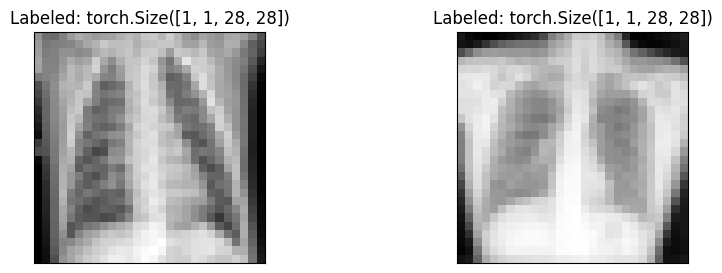

In [13]:
n_samples_show = 2

fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

for ind, (i,c) in enumerate(train_data):
    axes[ind].imshow(i[0,0], cmap="gray")
    axes[ind].set_xticks([])
    axes[ind].set_yticks([])
    axes[ind].set_title("Labeled: {}".format(i.shape))
    n_samples_show -= 1
    if n_samples_show == 0:
        break


**Modelo hibrido**

Primero se define una capa de de red neuronal cuántica, en este caso, un EstimatorQNN. Esta se puede incrustar inicializando un TorchConnector(qnn).

Para tener una retropropagación de gradiente adecuada en modelos híbridos, se establecera el parámetro inicial input_gradients en TRUE durante la inicialización de qnn.

In [14]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

En este punto se pueden crear diferentes combinaciones de capas y kernels. Mas adelante se mostrara una tabla con las combinaciones correspondientes.


In [19]:
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=3)
        self.conv2 = Conv2d(2, 16, kernel_size=3)
        self.conv3 = Conv2d(16, 64, kernel_size=3)
        self.dropout = Dropout2d()
        self.fc1 = Linear(64, 128)#238144, 64)
        self.fc2 = Linear(128, 64)  # 2-dimensional input to QNN
        self.fc3 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc4 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

**Manda llamar el modelo para entrenar**

El entrenamiento varia dependiendo de el número de epocas o iteraciones que se coloquen para el mismo. Para conocer el error que se va teniendo en la iteración con el fin de mejorar el algoritmo, se ocupa la función NLLLOSS, la cual obtiene la pérdida de probabilidad logarítmica negativa. Esto es útil entrenar un problema de clasificación donde el dataset esta desbalanceado.

In [20]:
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 20  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data,label) in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, label)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -1.7011
Training [10%]	Loss: -2.4804
Training [15%]	Loss: -3.1281
Training [20%]	Loss: -3.7477
Training [25%]	Loss: -4.3693
Training [30%]	Loss: -4.9791
Training [35%]	Loss: -5.5980
Training [40%]	Loss: -6.2114
Training [45%]	Loss: -6.8245
Training [50%]	Loss: -7.4322
Training [55%]	Loss: -8.0498
Training [60%]	Loss: -8.6626
Training [65%]	Loss: -9.2751
Training [70%]	Loss: -9.8824
Training [75%]	Loss: -10.5001
Training [80%]	Loss: -11.1126
Training [85%]	Loss: -11.7215
Training [90%]	Loss: -12.3376
Training [95%]	Loss: -12.9502
Training [100%]	Loss: -13.5605


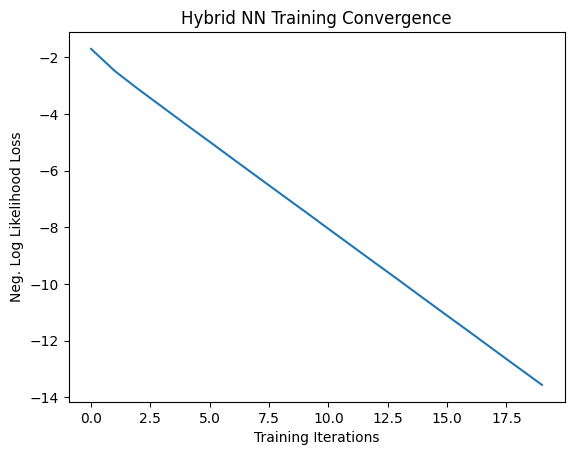

In [21]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Se guarda el modelo entrenado, para reutilizarlo más adelante y realizar inferencias.

In [23]:
torch.save(model4.state_dict(), "model4.pt")

**Evaluación**


Se recrea el modelo y se carga el estado del archivo previamente guardado. Se crea una capa QNN usando otro simulador

In [24]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [25]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_data):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_data) / 1 * 100
        )
    )

Performance on test data:
	Loss: -13.5411
	Accuracy: 85.2%


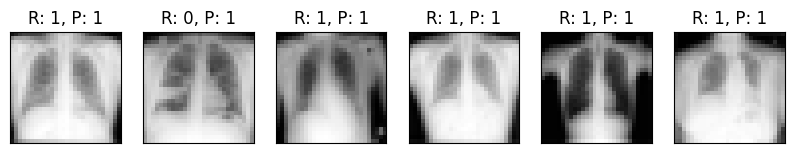

In [26]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_data):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        titulo = "R: "+str(target.item()) + ", P: "+ str(pred.item())
        axes[count].set_title(titulo)

        count += 1

Se realizaron las siguientes combinaciones del modelo:
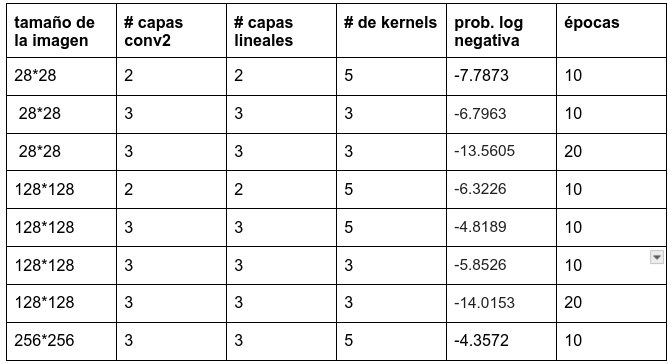

En este caso nuestro dataset, funciona muy bien si redimensionamos las imágenes a 28 * 28, ya que incluso todos los resultados  son mejores con este tamaño independiente de la combinación de capas o kernels. El resultado es muy bueno si se dejan 2 capas conv2d y 2 lineales y comienza a mejorar si se incrementa el número de épocas